In [1]:
import json
from pathlib import Path
import re
_IGNORED = ["sgkixz", "wximmp", "viyzyb", "knerph", "imaxnn", "nihtsk", "olnsio", "dummy"]
_DATA_DIR = Path("./data")

def get_raw_text(field_name, ignored_candidates=_IGNORED, data_dir=_DATA_DIR):
    result = {}
    for json_file in data_dir.glob("*.json"):
        with json_file.open("r", encoding="utf-8") as f:
            dataOfCandidates = json.load(f)
            for candidateId in dataOfCandidates:
                if any (i in candidateId for i in ignored_candidates):
                    continue
                motivational_letter: str = dataOfCandidates[candidateId][field_name]
                result[candidateId] = re.sub(r"\s", " ", motivational_letter)
    return result
data_motivations = get_raw_text("List motywacyjny")
data_research = get_raw_text("Opis projektu")


In [3]:
from collections import defaultdict
import spacy
import pandas as pd

model = "pl_core_news_lg"
nlp = spacy.load(model)

def sum_tree_lengths_from_refs(refs):
    return sum(
        sum(1 for _ in root.subtree)
        for root in refs
    )

def process_text(text):
    doc = nlp(text)

    first_person_sentences = defaultdict(set)

    for token in doc:
        if token.dep_ != "ROOT":
            continue
        person = token.morph.get("Person")
        if "1" in person:
            first_person_sentences[token.head].add(token)

    return {
        "self_references": sum_tree_lengths_from_refs(first_person_sentences),
        "total_size": len(doc),
    }

lengths = {
    candidate.removesuffix(""): process_text(data_motivations[candidate])
    for candidate in data_motivations
}

df = pd.DataFrame({
    "total_size": [lengths[candidate]["total_size"] for candidate in lengths],
    "self_references": [lengths[candidate]["self_references"] for candidate in lengths]
})


In [4]:
import pandas as pd

raw_rating = pd.read_csv("rating.csv", sep=";")

def reshape(df: pd.DataFrame, label):
    x = df.melt(
        id_vars=["Kod"],
        value_vars=[c for c in df.columns if c.startswith(label)],
        var_name="Oceniajacy",
        value_name=label,
    )
    x["Oceniajacy"] = x["Oceniajacy"].str.removeprefix(f"{label}_")
    return x


motivations = reshape(raw_rating, "motywacje")
motivations = motivations.set_index(["Kod"])
motivations = motivations.dropna()
motivations_score_0 = motivations[motivations["Oceniajacy"] == "1"]["motywacje"]
motivations_score_0

motivations_score_0 = motivations_score_0.reindex([e.removesuffix("@gfps.pl") for e in lengths.keys()])

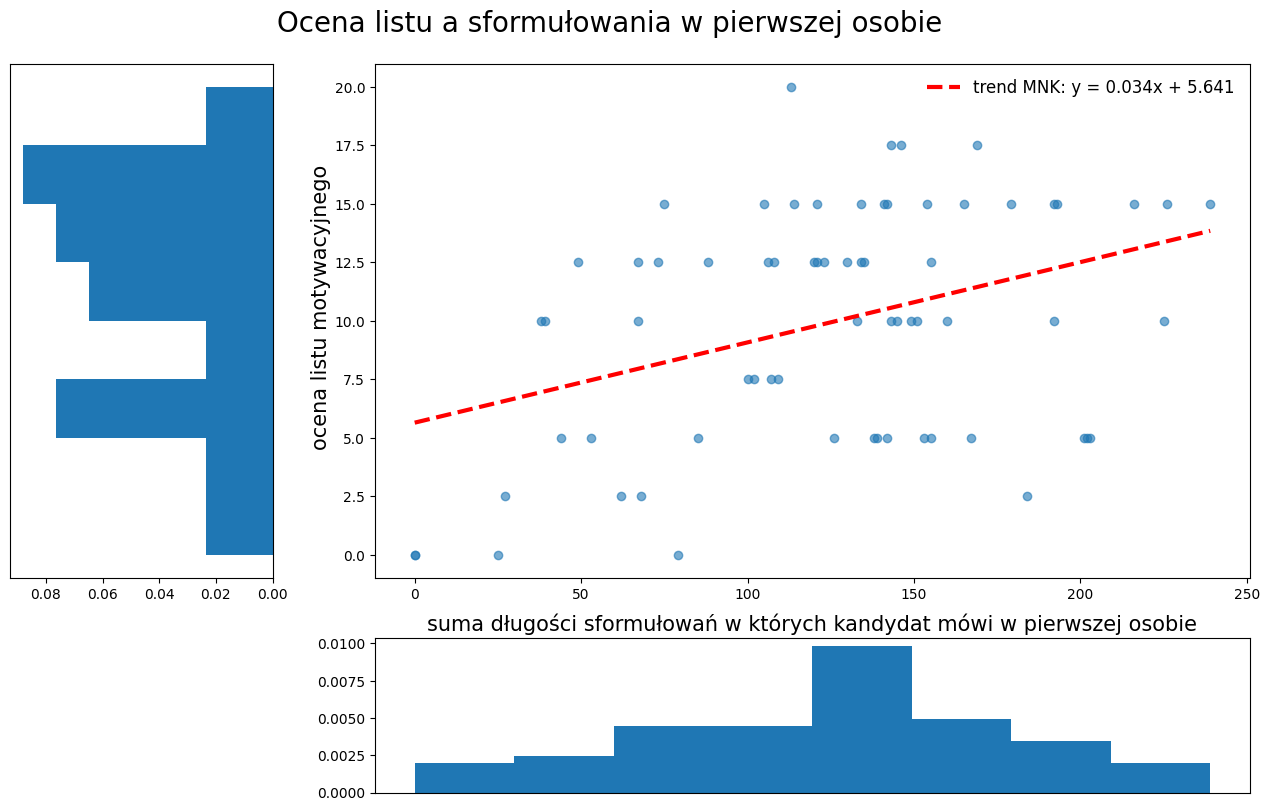

In [41]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

X = np.array([x for x in df["self_references"]])
Y = np.array([int(e/2.5) * 2.5 for e in motivations_score_0]).astype(float)

fig = plt.figure(figsize=(16, 9))
gs = GridSpec(
    2, 2,
    width_ratios=[1.2, 4],
    height_ratios=[4, 1.2],
    wspace=0.18,
    hspace=0.18
)

ax_scatter = fig.add_subplot(gs[0, 1])
ax_hist_y  = fig.add_subplot(gs[0, 0], sharey=ax_scatter)
ax_hist_x  = fig.add_subplot(gs[1, 1], sharex=ax_scatter)

# --- Scatter ---
ax_scatter.scatter(X, Y, alpha=0.6)

# --- TREND: metoda najmniejszych kwadratów ---
# y = a*x + b
a, b = np.polyfit(X, Y, 1)

x_line = np.linspace(X.min(), X.max(), 200)
y_line = a * x_line + b

ax_scatter.plot(
    x_line,
    y_line,
    linewidth=3,
    color='red',
    linestyle="--",
    label=f"trend MNK: y = {a:.3f}x + {b:.3f}"
)

ax_scatter.legend(frameon=False, fontsize=12)

# --- Labelki na centralnym wykresie ---
ax_scatter.set_xlabel(
    "suma długości sformułowań w których kandydat mówi w pierwszej osobie",
    fontsize=15
)
ax_scatter.set_ylabel(
    "ocena listu motywacyjnego",
    fontsize=15
)

ax_scatter.xaxis.set_label_coords(0.5, -0.11)
ax_scatter.yaxis.set_label_coords(-0.05, 0.25)

ax_scatter.xaxis.label.set_verticalalignment("bottom")
ax_scatter.yaxis.label.set_horizontalalignment("left")

fig.suptitle(
    "Ocena listu a sformułowania w pierwszej osobie",
    fontsize=20
)

# --- Histogram Y (lewy) – znormalizowany ---
ax_hist_y.hist(Y, bins="auto", orientation="horizontal", density=True)
ax_hist_y.invert_xaxis()

# --- Histogram X (dolny) – znormalizowany ---
ax_hist_x.hist(X, bins="auto", density=True)

# --- Ukrywanie ticków histogramów ---
ax_hist_x.tick_params(axis="x", bottom=False, labelbottom=False)
ax_hist_y.tick_params(axis="y", left=False, labelleft=False)

ax_hist_x.set_xlabel("")
ax_hist_y.set_ylabel("")

plt.subplots_adjust(top=0.92)
plt.show()


In [56]:
lower

array([11.25,  3.75,  8.75,  1.25, 13.75,  3.75, 13.75, 13.75, 16.25,
        8.75, 13.75, 11.25,  3.75, 11.25, 11.25, 11.25,  0.  , 13.75,
        8.75, 13.75, 11.25, 13.75,  6.25,  3.75, 16.25,  3.75,  8.75,
        8.75, 13.75, 13.75,  3.75,  3.75, 11.25,  3.75,  6.25, 13.75,
       13.75, 13.75, 11.25,  8.75,  3.75, 13.75,  0.  ,  0.  ,  0.  ,
       11.25, 11.25,  6.25,  3.75,  8.75, 18.75, 11.25, 11.25,  1.25,
        8.75,  8.75,  8.75,  6.25, 13.75, 11.25,  8.75, 16.25, 13.75,
        3.75,  1.25,  3.75,  1.25,  3.75])

In [57]:
import numpy as np
import pymc as pm
import arviz as az

x = X
y = Y

step = 2.5

lower = 0
upper = 20

with pm.Model() as m:
    beta  = pm.Normal("beta", 0, 5)
    alpha = pm.Normal("alpha", 0, 5)

    sigma = pm.HalfNormal("sigma", 12)

    mu =  beta * X + alpha

    base = pm.Normal.dist(mu=mu, sigma=sigma)
    y_obs = pm.Censored("y_obs", base, lower=lower, upper=upper, observed=Y)

    idata_robust = pm.sample(2000, tune=2000, chains=4, target_accept=0.99, random_seed=0)

print(az.summary(idata_robust, var_names=["alpha", "beta", "sigma"], round_to=3))


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, sigma]


/home/kubajal/development/bayes/venv/lib/python3.10/site-packages/rich/live.py:260: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 5 seconds.


        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  4.419  1.551   1.533    7.393      0.032    0.024  2358.325  2725.598   
beta   0.043  0.011   0.020    0.064      0.000    0.000  2373.030  2574.890   
sigma  5.137  0.487   4.306    6.108      0.009    0.007  3116.526  3540.769   

       r_hat  
alpha  1.002  
beta   1.001  
sigma  1.000  


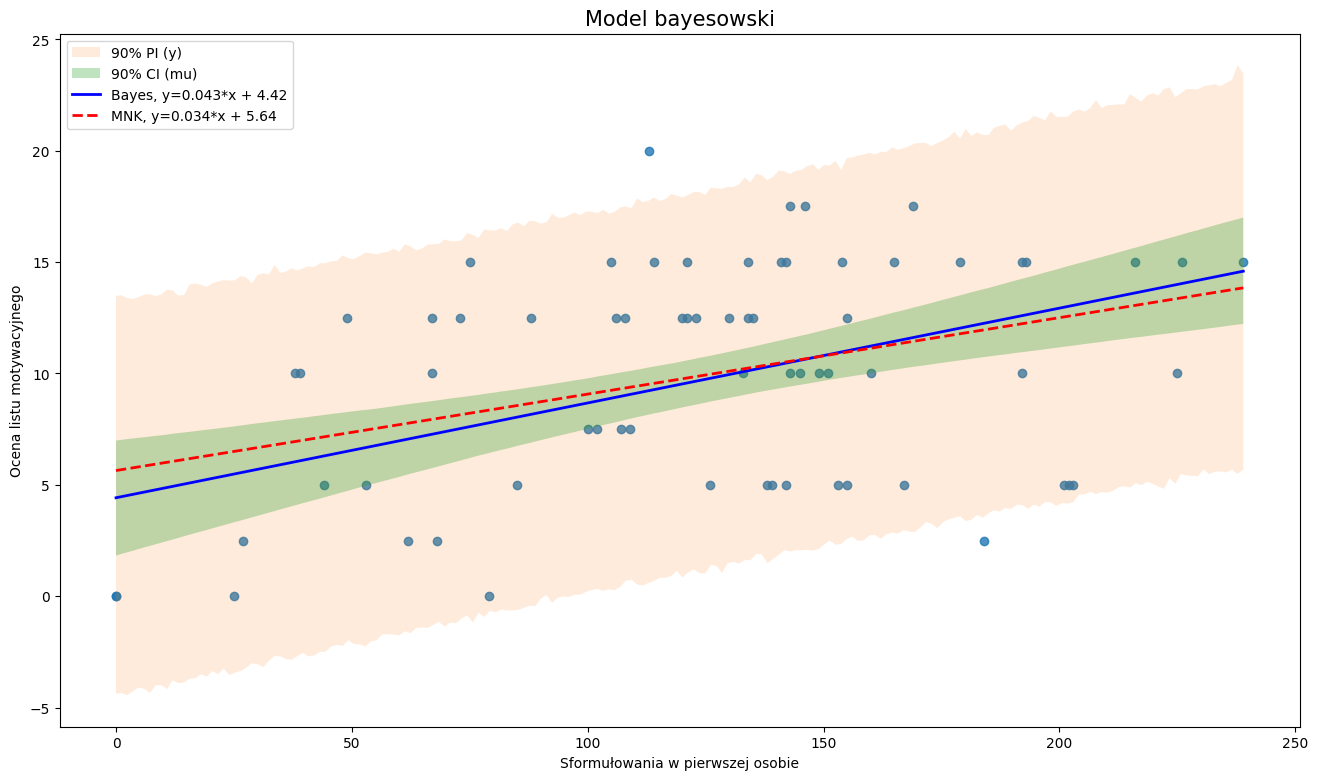

In [62]:
import numpy as np
import matplotlib.pyplot as plt

x = df["self_references"].to_numpy().astype(float)
y = np.array([int(e/2.5) * 2.5 for e in motivations_score_0]).astype(float)

# siatka do rysowania
x_grid = np.linspace(x.min(), x.max(), 200)
x_grid_z = x_grid

# próbki z posteriora (w skali z-score Y)
alpha_s = idata_robust.posterior["alpha"].values.ravel()
beta_s  = idata_robust.posterior["beta"].values.ravel()
sigma_s = idata_robust.posterior["sigma"].values.ravel()

# predykcja średniej w skali z-score
mu_z_s = alpha_s[:, None] + beta_s[:, None] * x_grid_z[None, :]

# odstandaryzowanie: z-score -> oryginalna skala Y
mu_s = mu_z_s
sigma_orig_s = sigma_s

# linia i CI dla średniej
mu_mean = mu_s.mean(axis=0)
mu_lo, mu_hi = np.percentile(mu_s, [5, 95], axis=0)

# predykcyjny przedział dla obserwacji (oryginalna skala)
y_pred_s = mu_s + np.random.normal(0, sigma_orig_s[:, None], size=mu_s.shape)
pp_lo, pp_hi = np.percentile(y_pred_s, [5, 95], axis=0)

# --- rysowanie ---
plt.figure(figsize=(16, 9))
plt.scatter(x, y, alpha=0.8)

plt.fill_between(x_grid, pp_lo, pp_hi, alpha=0.15, label="90% PI (y)")
plt.fill_between(x_grid, mu_lo, mu_hi, alpha=0.30, label="90% CI (mu)")
bayes_beta, bayes_alpha = (beta_s.mean(), alpha_s.mean())
y_bayes = bayes_alpha + bayes_beta * x_grid
# plt.plot(x_grid, mu_mean, linewidth=6, label="E[y|x] (prosta)")
plt.plot(
    x_grid,
    y_bayes,
    color="blue",
    linestyle="-",
    linewidth=2,
    label=f"Bayes, y={bayes_beta:.3f}*x + {bayes_alpha:.3}"
)


ols_beta, ols_alpha = np.polyfit(x, y, 1)
y_ols = ols_alpha + ols_beta * x_grid

plt.plot(
    x_grid,
    y_ols,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"MNK, y={ols_beta:.3f}*x + {ols_alpha:.3}"
)

plt.xlabel("Sformułowania w pierwszej osobie")
plt.ylabel("Ocena listu motywacyjnego")
plt.title("Model bayesowski", fontsize=15)
plt.legend()
plt.show()


In [ ]:

slope_unit_s = beta_s / x_std
print("E(slope per 1 unit X) =", slope_unit_s.mean())
print("90% CI slope per unit =", np.percentile(slope_unit_s, [5, 95]))

E(slope per 1 unit X) = 0.008585323721051814
90% CI slope per unit = [0.00313671 0.01390681]


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

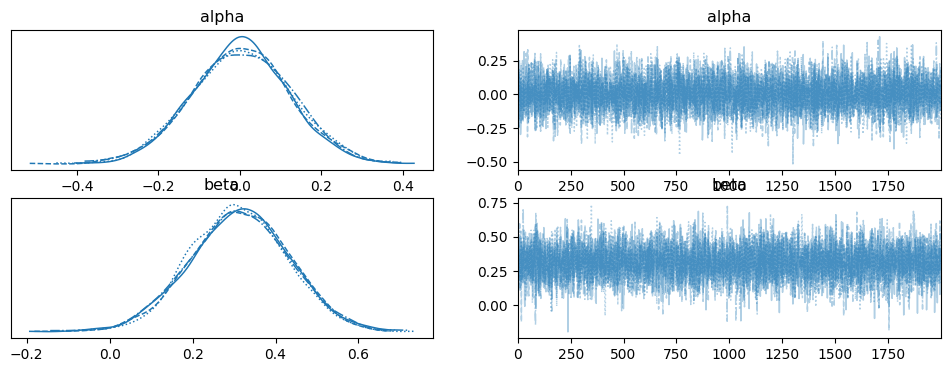

In [34]:
import arviz as az

az.plot_trace(idata_robust, var_names=["alpha", "beta"])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, sigma]


/home/kubajal/development/llms/venv/lib/python3.10/site-packages/rich/live.py:260: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 800 tune and 800 draw iterations (1_600 + 1_600 draws total) took 1 seconds.
There were 121 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, sigma]


/home/kubajal/development/llms/venv/lib/python3.10/site-packages/rich/live.py:260: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 800 tune and 800 draw iterations (1_600 + 1_600 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, sigma]


/home/kubajal/development/llms/venv/lib/python3.10/site-packages/rich/live.py:260: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 800 tune and 800 draw iterations (1_600 + 1_600 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, sigma]


/home/kubajal/development/llms/venv/lib/python3.10/site-packages/rich/live.py:260: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 800 tune and 800 draw iterations (1_600 + 1_600 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, sigma]


/home/kubajal/development/llms/venv/lib/python3.10/site-packages/rich/live.py:260: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 800 tune and 800 draw iterations (1_600 + 1_600 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


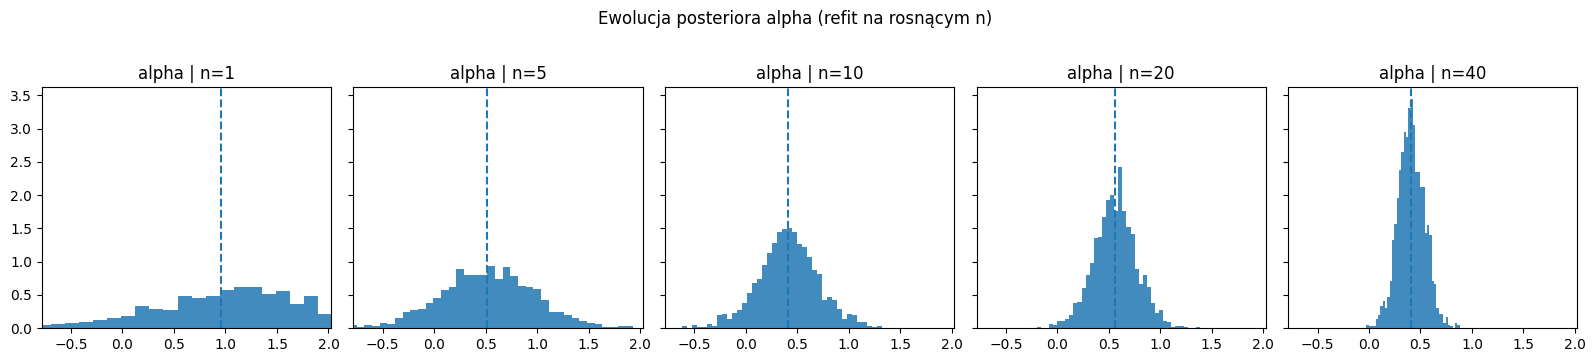

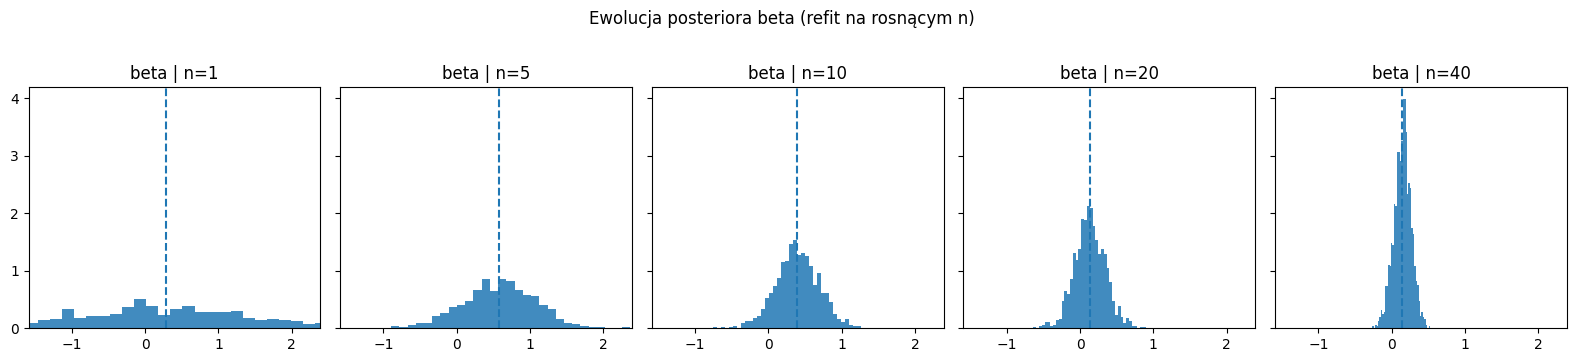

In [ ]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

def bayes_refit_prefix_posteriors(
    x, y,
    n_list=(1, 5, 10, 20, 40, 80, 160, 320),
    standardize_y=False,
    draws=2000, tune=2000, chains=4, target_accept=0.9,
    seed=42
):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    # --- standaryzacja X (jak u Ciebie) ---
    x_mean, x_std = x.mean(), x.std()
    x_z = (x - x_mean) / x_std

    # --- standaryzacja Y (opcjonalnie) ---
    if standardize_y:
        y_mean, y_std = y.mean(), y.std()
        y_used = (y - y_mean) / y_std
    else:
        y_mean, y_std = y.mean(), y.std()
        y_used = y

    idatas = []
    used_ns = []

    # --- Model z MutableData: budujesz raz ---
    with pm.Model() as m:
        x_data = pm.Data("x_data", x_z[:n_list[0]])
        y_data = pm.Data("y_data", y_used[:n_list[0]])

        alpha = pm.Normal("alpha", 0.0, 1.0) if standardize_y else pm.Normal("alpha", mu=y.mean(), sigma=10.0)
        beta  = pm.HalfNormal("beta", 1.0)  # efekt na 1 SD X (i 1 SD Y jeśli standaryzujesz y)
        sigma = pm.HalfNormal("sigma", 1.0) if standardize_y else pm.HalfNormal("sigma", 5.0)

        mu = alpha + beta * x_data
        pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_data)

        # --- Refity dla kolejnych n ---
        for n in n_list:
            if n > len(x_z):
                break

            pm.set_data({"x_data": x_z[:n], "y_data": y_used[:n]})
            idata_n = pm.sample(
                draws=draws, tune=tune, chains=chains,
                target_accept=target_accept, random_seed=seed,
                progressbar=True
            )
            idatas.append(idata_n)
            used_ns.append(n)

    # --- Rysowanie: posterior alpha i beta dla kolejnych n ---
    # Ustal wspólne zakresy osi, żeby panele były porównywalne
    alpha_all = np.concatenate([id.posterior["alpha"].values.reshape(-1) for id in idatas])
    beta_all  = np.concatenate([id.posterior["beta"].values.reshape(-1)  for id in idatas])

    a_lo, a_hi = np.percentile(alpha_all, [0.5, 99.5])
    b_lo, b_hi = np.percentile(beta_all,  [0.5, 99.5])

    cols = 5
    rows = int(np.ceil(len(used_ns) / cols))

    # --- alpha ---
    fig, axes = plt.subplots(rows, cols, figsize=(16, 3.5*rows), sharex=True, sharey=True)
    axes = np.ravel(axes)

    for i, (n, idata_n) in enumerate(zip(used_ns, idatas)):
        s = idata_n.posterior["alpha"].values.reshape(-1)
        ax = axes[i]
        ax.hist(s, bins=40, density=True, alpha=0.85)
        ax.axvline(s.mean(), linestyle="--")
        ax.set_title(f"alpha | n={n}")
        ax.set_xlim(a_lo, a_hi)

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Ewolucja posteriora alpha (refit na rosnącym n)", y=1.02)
    plt.tight_layout()
    plt.show()

    # --- beta ---
    fig, axes = plt.subplots(rows, cols, figsize=(16, 3.5*rows), sharex=True, sharey=True)
    axes = np.ravel(axes)

    for i, (n, idata_n) in enumerate(zip(used_ns, idatas)):
        s = idata_n.posterior["beta"].values.reshape(-1)
        ax = axes[i]
        ax.hist(s, bins=40, density=True, alpha=0.85)
        ax.axvline(s.mean(), linestyle="--")
        ax.set_title(f"beta | n={n}")
        ax.set_xlim(b_lo, b_hi)

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Ewolucja posteriora beta (refit na rosnącym n)", y=1.02)
    plt.tight_layout()
    plt.show()

    return idatas, used_ns, (x_mean, x_std, y_mean, y_std)

x = df["self_references"].to_numpy().astype(float)
y = np.asarray(motivations_score_0, dtype=float)

idatas, used_ns, stats = bayes_refit_prefix_posteriors(
    x, y,
    n_list=(1, 5, 10, 20, 40, 80, 120),   # dobierz pod rozmiar danych
    standardize_y=True,
    draws=800, tune=800, chains=2
)
